<a href="https://colab.research.google.com/github/BhardwajArjit/Research-Paper-Replication/blob/main/CaaM_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook replicates the research paper titled "**Causal Attention for Unbiased Visual Recognition**" with PyTorch.

The link to the paper: https://arxiv.org/abs/2108.08782

**Causal Attention Module** (CaaM) generates data partition iteratively and self-annotates the confounders progressively to overcome the over-adjustment problem.

The ultimate goal of CaaM is to improve causal inference by adjusting for confounders more accurately.

##0. Get setup

In [1]:
try:
  import torch
  import torchvision
  import timm
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
  print(f"timm version: {timm.__version__}")
except:
  print(f"[INFO] Couldn't find timm... installing it.")
  !pip install timm
  import timm
  print(f"timm {timm.__version__} installed successfully...")

[INFO] Couldn't find timm... installing it.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
timm 0.9.11 installed successfully...


In [2]:
import matplotlib.pyplot as plt
import math
import torch
import torchvision

from torch import nn
from torch.nn import init
import torch.nn.functional as F
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  print("torchinfo installed successfully...")
  from torchinfo import summary

# try:
#     from pytorch_utils import download_data, set_seeds, plot_loss_curves
# except ImportError:
#     # If the import fails, clone the repository
#     !git clone https://github.com/BhardwajArjit/Helper-Functions.git
#     !mv Helper-Functions/pytorch_utils.py .
#     !rm -rf Helper-Functions
#     from pytorch_utils import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
torchinfo installed successfully...


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# GPU provided by Google Colab
!nvidia-smi

Tue Nov 21 09:02:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##1. Get Data

The dataset that the researchers have used is the animal subset of NICO.

The google drive link to the provided dataset: https://drive.google.com/drive/folders/17-jl0fF9BxZupG75BtpOqJaB6dJ2Pv8O?usp=sharing

This notebook is currently using the subset of this dataset provided by the researchers for faster computation and experimentation.

The dataset (ours currently) contains:

1. 75 images for training of 3 different classes: bird, rat and sheep.
2. 30 images for testing purposes.

The link to the current dataset: https://github.com/BhardwajArjit/Research-Paper-Replication/raw/main/nico_subset.zip

The whole point is to speed up how fast we can experiment.

In [5]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "nico_subset"

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "nico_subset.zip", "wb") as f:
  request = requests.get("https://github.com/BhardwajArjit/Research-Paper-Replication/raw/main/nico_subset.zip")
  print("Downloading nico subset data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "nico_subset.zip", "r") as zip_ref:
  print(f"Uzipping nico subset data...")
  zip_ref.extractall(data_path)

data/nico_subset does not exist, creating one...
Uzipping nico subset data...


##2. Becoming one with the data (data preparation and data exploration)

In [6]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/nico_subset'.
There are 3 directories and 0 images in 'data/nico_subset/test'.
There are 0 directories and 10 images in 'data/nico_subset/test/bird'.
There are 0 directories and 10 images in 'data/nico_subset/test/rat'.
There are 0 directories and 10 images in 'data/nico_subset/test/sheep'.
There are 3 directories and 0 images in 'data/nico_subset/train'.
There are 0 directories and 25 images in 'data/nico_subset/train/bird'.
There are 0 directories and 25 images in 'data/nico_subset/train/rat'.
There are 0 directories and 25 images in 'data/nico_subset/train/sheep'.


In [8]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/nico_subset/train'), PosixPath('data/nico_subset/test'))

## 2.1 Visualizing an image

Random image path: data/nico_subset/test/rat/2_3_31.jpg
Image class: rat
Image height: 866
Image width: 1300


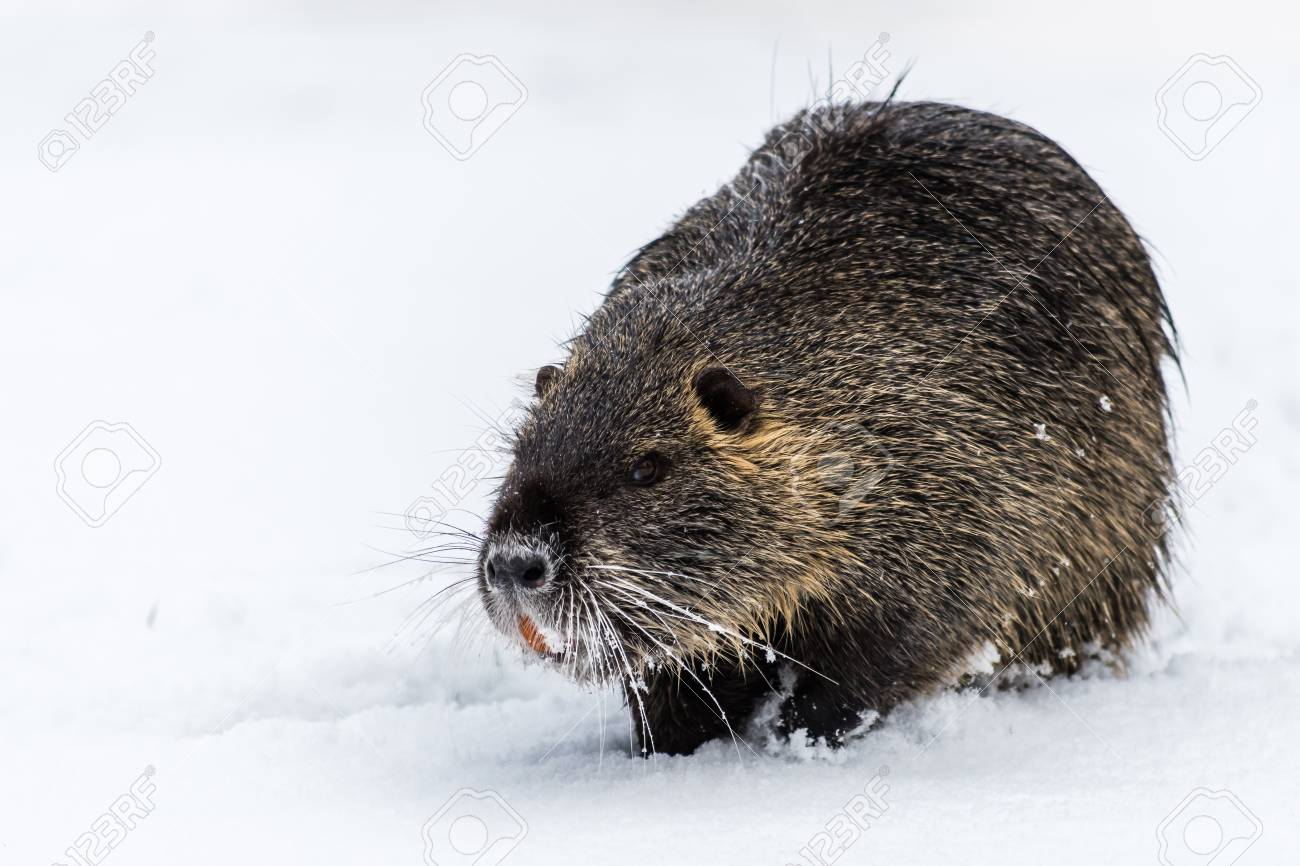

In [9]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

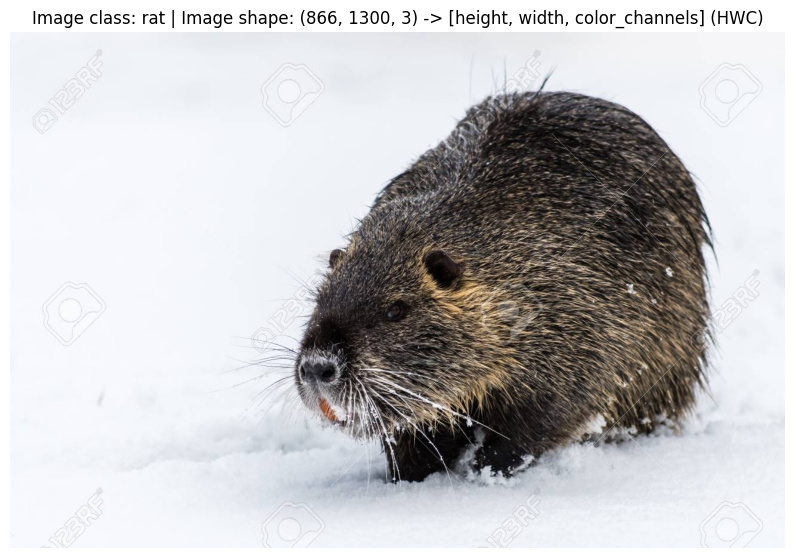

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

In [11]:
img_as_array

array([[[245, 246, 251],
        [245, 246, 251],
        [245, 246, 251],
        ...,
        [246, 246, 248],
        [246, 246, 248],
        [246, 246, 248]],

       [[245, 246, 251],
        [245, 246, 251],
        [245, 246, 251],
        ...,
        [246, 246, 248],
        [246, 246, 248],
        [246, 246, 248]],

       [[245, 246, 251],
        [245, 246, 251],
        [245, 246, 251],
        ...,
        [246, 246, 248],
        [246, 246, 248],
        [246, 246, 248]],

       ...,

       [[248, 249, 254],
        [248, 249, 254],
        [248, 249, 254],
        ...,
        [244, 247, 252],
        [244, 247, 252],
        [244, 247, 252]],

       [[248, 249, 254],
        [248, 249, 254],
        [248, 249, 254],
        ...,
        [243, 246, 251],
        [243, 246, 251],
        [243, 246, 251]],

       [[248, 249, 254],
        [248, 249, 254],
        [248, 249, 254],
        ...,
        [243, 246, 251],
        [243, 246, 251],
        [243, 246, 251]]

## 3. Transform data

Before we can use our image data with PyTorch:

1. Turn our target data into tensors.
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with `torchvision.transforms`

In [13]:
data_transform = transforms.Compose([
    #Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into torch.Tensor
    transforms.ToTensor()
])

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

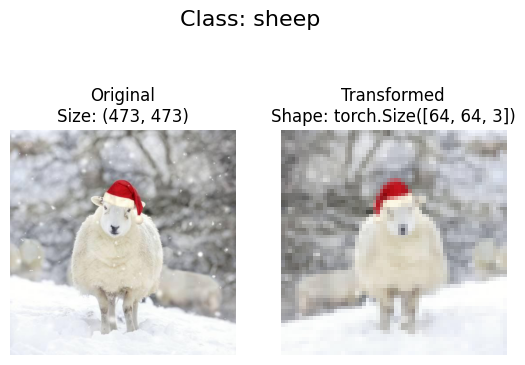

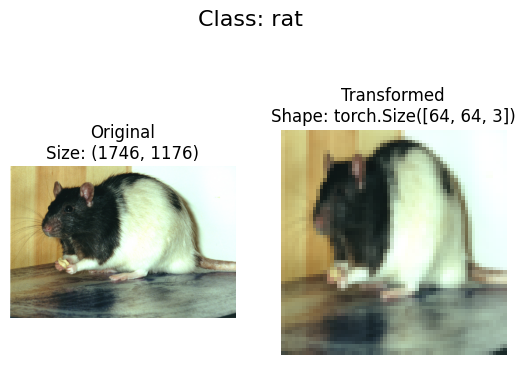

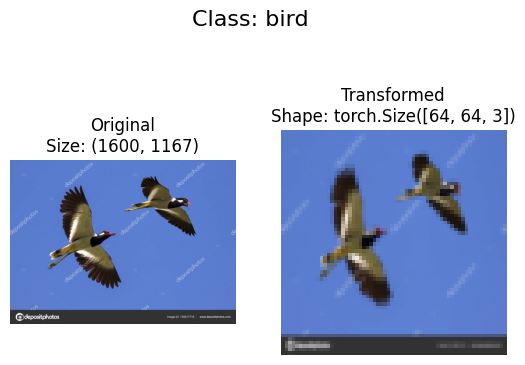

In [15]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 3.2 Loading image data using `ImageFolder`

In [16]:
# Use ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/nico_subset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 29
     Root location: data/nico_subset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
train_dir, test_dir

(PosixPath('data/nico_subset/train'), PosixPath('data/nico_subset/test'))

In [18]:
# Get class names as list
class_names = train_data.classes
class_names

['bird', 'rat', 'sheep']

In [19]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'bird': 0, 'rat': 1, 'sheep': 2}

In [20]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(75, 29)

In [21]:
train_data.samples[0]

('data/nico_subset/train/bird/1_11_177.jpg', 0)

In [22]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.3608, 0.4353, 0.4706,  ..., 0.1451, 0.1412, 0.1412],
         [0.1529, 0.1725, 0.2039,  ..., 0.1608, 0.1529, 0.1490],
         [0.0941, 0.1020, 0.1255,  ..., 0.1608, 0.1529, 0.1451],
         ...,
         [0.4510, 0.4235, 0.4667,  ..., 0.3686, 0.3765, 0.2824],
         [0.4078, 0.4039, 0.4431,  ..., 0.2941, 0.2863, 0.2314],
         [0.4235, 0.4353, 0.4588,  ..., 0.3176, 0.3059, 0.3059]],

        [[0.3373, 0.4039, 0.4353,  ..., 0.1333, 0.1294, 0.1294],
         [0.1529, 0.1725, 0.1961,  ..., 0.1490, 0.1412, 0.1373],
         [0.1098, 0.1176, 0.1373,  ..., 0.1529, 0.1412, 0.1294],
         ...,
         [0.4510, 0.4314, 0.4588,  ..., 0.3686, 0.3765, 0.2941],
         [0.4078, 0.4000, 0.4314,  ..., 0.2941, 0.2980, 0.2471],
         [0.4118, 0.4275, 0.4510,  ..., 0.3098, 0.2902, 0.3059]],

        [[0.3451, 0.4157, 0.4471,  ..., 0.0902, 0.0941, 0.1020],
         [0.1647, 0.1804, 0.2039,  ..., 0.1137, 0.1098, 0.1098],
         [0.1216, 0.1255, 0.1490,  ..., 0.1

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'bird')

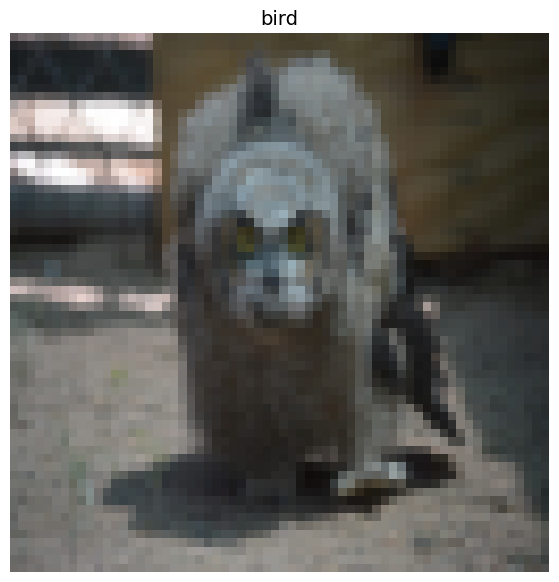

In [23]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 3.3 Turn loaded images into `DataLoader`

In [24]:
import os
os.cpu_count()

2

In [25]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a60440904f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a6041e39870>)

In [26]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 3.3 Create a function to display random images

In [27]:
from typing import Tuple, Dict, List
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

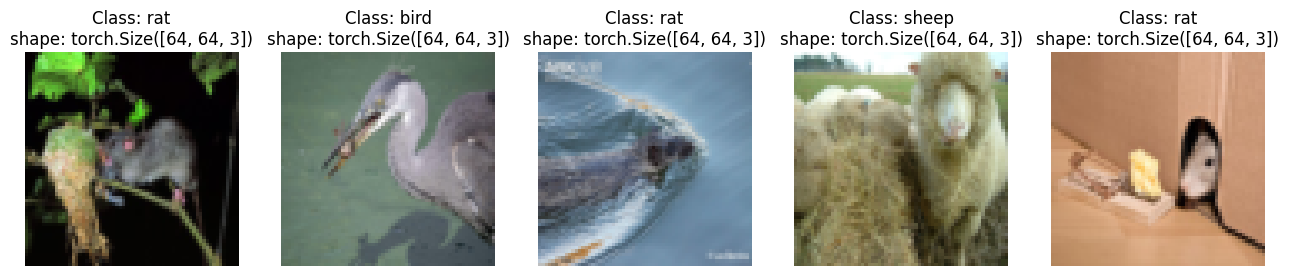

In [28]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

## 4. BAM implementation

In [29]:
class BAMFlatten(nn.Module):
  """
  Flatten operation for the input tensor.

  Parameters:
  - x (torch.Tensor): Input tensor.

  Returns:
  - torch.Tensor: Flattened tensor.
  """
  def forward(self, x):
    return x.view(x.size(0), -1)

In [30]:
class BAMChannelGate(nn.Module):
  """
  Bottleneck Attention Module (BAM) - Channel Gate.

  Parameters:
  - gate_channel (int): Number of input channels for the gate.
  - reduction_ratio (int, optional): Reduction ratio for the intermediate channels. Default is 16.
  - num_layers (int, optional): Number of linear layers in the gate. Default is 1.
  """
  def __init__(self,
                gate_channel,
                reduction_ratio=16,
                num_layers=1):
    super(BAMChannelGate, self).__init__()

    # Define the components of the channel gate
    self.gate_activation = gate_activation
    self.gate_c = nn.Sequential()
    self.gate_c.add_module( 'flatten', BAMFlatten() )

    # Define the number of channels for each layer in the gate
    gate_channels = [gate_channel]
    gate_channels += [gate_channel // reduction_ratio] * num_layers
    gate_channels += [gate_channel]

    # Create linear layers with batch normalization and ReLU activation
    for i in range( len(gate_channels) - 2 ):
      self.gate_c.add_module( 'gate_c_fc_%d'%i, nn.Linear(gate_channels[i], gate_channels[i+1]) )
      self.gate_c.add_module( 'gate_c_bn_%d'%(i+1), nn.BatchNorm1d(gate_channels[i+1]) )
      self.gate_c.add_module( 'gate_c_relu_%d'%(i+1), nn.ReLU() )

    # Final linear layer without activation
    self.gate_c.add_module( 'gate_c_fc_final', nn.Linear(gate_channels[-2], gate_channels[-1]) )

  def forward(self, in_tensor):
    # Apply global average pooling to the input tensor
    avg_pool = F.avg_pool2d( in_tensor, in_tensor.size(2), stride=in_tensor.size(2) )

    # Apply the channel gate to the averaged features and expand the dimensions
    return self.gate_c( avg_pool ).unsqueeze(2).unsqueeze(3).expand_as(in_tensor)

In [31]:
class BAMSpatialGate(nn.Module):
  """
  Bottleneck Attention Module (BAM) - Spatial Gate.

  Parameters:
  - gate_channel (int): Number of input channels for the gate.
  - reduction_ratio (int, optional): Reduction ratio for the intermediate channels. Default is 16.
  - dilation_conv_num (int, optional): Number of dilated convolutions in the gate. Default is 2.
  - dilation_val (int, optional): Dilation value for the dilated convolutions. Default is 4.
  """
  def __init__(self,
                gate_channel,
                reduction_ratio=16,
                dilation_conv_num=2,
                dilation_val=4):
    super(BAMSpatialGate, self).__init__()

    # Define the components of the spatial gate
    self.gate_s = nn.Sequential()

    # Reduce dimensionality using 1x1 convolution
    self.gate_s.add_module( 'gate_s_conv_reduce0', nn.Conv2d(gate_channel, gate_channel//reduction_ratio, kernel_size=1))
    self.gate_s.add_module( 'gate_s_bn_reduce0',	nn.BatchNorm2d(gate_channel//reduction_ratio) )
    self.gate_s.add_module( 'gate_s_relu_reduce0',nn.ReLU() )

    # Apply dilated convolutions
    for i in range( dilation_conv_num ):
      self.gate_s.add_module( 'gate_s_conv_di_%d'%i, nn.Conv2d(gate_channel//reduction_ratio, gate_channel//reduction_ratio, kernel_size=3, \
      padding=dilation_val, dilation=dilation_val) )
      self.gate_s.add_module( 'gate_s_bn_di_%d'%i, nn.BatchNorm2d(gate_channel//reduction_ratio) )
      self.gate_s.add_module( 'gate_s_relu_di_%d'%i, nn.ReLU() )

    # Final 1x1 convolution to produce spatial attention map
    self.gate_s.add_module( 'gate_s_conv_final', nn.Conv2d(gate_channel//reduction_ratio, 1, kernel_size=1) )

  def forward(self, in_tensor):
    # Apply the spatial gate to the input tensor and expand the dimensions
    return self.gate_s( in_tensor ).expand_as(in_tensor)

In [32]:
class BAM(nn.Module):
  """
  Bottleneck Attention Module (BAM).

  Parameters:
  - gate_channel (int): Number of input channels for the gate.
  """
  def __init__(self, gate_channel):
    super(BAM, self).__init__()

    # Channel-wise attention module
    self.channel_att = BAMChannelGate(gate_channel)

    # Spatial-wise attention module
    self.spatial_att = BAMSpatialGate(gate_channel)

  def forward(self,in_tensor):
    """
    Forward pass of the BAM module.

    Parameters:
    - in_tensor (torch.Tensor): Input tensor.

    Returns:
    - torch.Tensor: Output tensor after applying BAM.
    """
    # Calculate attention weights using channel and spatial attention modules
    att = 1 + F.sigmoid( self.channel_att(in_tensor) * self.spatial_att(in_tensor) )

    # Multiply the input tensor by the attention weights
    return att * in_tensor

## 5. CBAM implementation

In [33]:
class BasicConv(nn.Module):
  """
  Basic Convolutional Block.

  Parameters:
  - in_planes (int): Number of input channels.
  - out_planes (int): Number of output channels.
  - kernel_size (int or tuple): Size of the convolutional kernel.
  - stride (int, optional): Stride for the convolution operation. Default is 1.
  - padding (int, optional): Padding added to both sides of the input. Default is 0.
  - dilation (int, optional): Spacing between kernel elements. Default is 1.
  - groups (int, optional): Number of blocked connections from input channels to output channels. Default is 1.
  - relu (bool, optional): Whether to include ReLU activation. Default is True.
  - bn (bool, optional): Whether to include Batch Normalization. Default is True.
  - bias (bool, optional): Whether to include bias in the convolution operation. Default is False.
  """
  def __init__(self,
                in_planes,
                out_planes,
                kernel_size,
                stride=1,
                padding=0,
                dilation=1,
                groups=1,
                relu=True,
                bn=True,
                bias=False):
    super(BasicConv, self).__init__()
    self.out_channels = out_planes

    # Convolutional layer
    self.conv = nn.Conv2d(in_planes,
                          out_planes,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding,
                          dilation=dilation,
                          groups=groups,
                          bias=bias)

    # Batch Normalization layer
    self.bn = nn.BatchNorm2d(out_planes,
                             eps=1e-5,
                             momentum=0.01,
                             affine=True) if bn else None

    # ReLU activation function
    self.relu = nn.ReLU() if relu else None

  def forward(self, x):
    """
    Forward pass of the BasicConv module.

    Parameters:
    - x (torch.Tensor): Input tensor.

    Returns:
    - torch.Tensor: Output tensor after applying convolution, batch normalization, and activation.
    """
    x = self.conv(x)
    if self.bn is not None:
      x = self.bn(x)
    if self.relu is not None:
      x = self.relu(x)
    return x

In [34]:
class CBAMFlatten(nn.Module):
  """
  Flatten operation for the input tensor.

  Parameters:
  - x (torch.Tensor): Input tensor.

  Returns:
  - torch.Tensor: Flattened tensor.
  """
  def forward(self, x):
    return x.view(x.size(0), -1)

In [35]:
class CBAMChannelGate(nn.Module):
  """
  Convolutional Block Attention Module (CBAM) - Channel Gate.

  Parameters:
  - gate_channels (int): Number of input channels for the gate.
  - reduction_ratio (int, optional): Reduction ratio for the intermediate channels. Default is 16.
  - pool_types (list, optional): Pooling types for aggregating information. Default is ['avg', 'max'].
  """
  def __init__(self,
              gate_channels,
              reduction_ratio=16,
              pool_types=['avg', 'max']):
    super(CBAMChannelGate, self).__init__()

    self.gate_channels = gate_channels

    # Multi-layer perceptron (MLP) for modeling channel dependencies
    self.mlp = nn.Sequential(
      CBAMFlatten(),
      nn.Linear(gate_channels, gate_channels // reduction_ratio),
      nn.ReLU(),
      nn.Linear(gate_channels // reduction_ratio, gate_channels)
      )

    self.pool_types = pool_types

  def forward(self, x, return_attn=False):
    channel_att_sum = None

    # Iterate over different pooling types
    for pool_type in self.pool_types:
        if pool_type=='avg':
          avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
          channel_att_raw = self.mlp( avg_pool )
        elif pool_type=='max':
          max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
          channel_att_raw = self.mlp( max_pool )
        elif pool_type=='lp':
          lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
          channel_att_raw = self.mlp( lp_pool )
        elif pool_type=='lse':
          # Log-sum-exp pool only
          lse_pool = logsumexp_2d(x)
          channel_att_raw = self.mlp( lse_pool )

        if channel_att_sum is None:
          channel_att_sum = channel_att_raw
        else:
          channel_att_sum = channel_att_sum + channel_att_raw

    # Sigmoid activation to produce attention weights between 0 and 1
    scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
    if return_attn:
      return x * scale, scale
    else:
      return x * scale

In [36]:
def logsumexp_2d(tensor):
  """
  Compute the log-sum-exp operation along the spatial dimensions of a 3D tensor.

  Parameters:
  - tensor (torch.Tensor): Input tensor.

  Returns:
  - torch.Tensor: Output tensor after log-sum-exp operation.
  """
  # Flatten the tensor along the spatial dimensions
  tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)

  # Compute the maximum value along the flattened dimensions
  s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)

  # Compute log-sum-exp operation along the flattened dimensions
  outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()

  return outputs

In [37]:
class ChannelPool(nn.Module):
  """
  Perform channel pooling on the input tensor.

  Parameters:
  - x (torch.Tensor): Input tensor.

  Returns:
  - torch.Tensor: Output tensor after channel pooling.
  """
  def forward(self, x):
    # Concatenate the maximum and mean values along the channel dimension
    return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

In [38]:
class CBAMSpatialGate(nn.Module):
  """
  Convolutional Block Attention Module (CBAM) - Spatial Gate.
  """
  def __init__(self):
    super(CBAMSpatialGate, self).__init__()

    # Channel pooling operation
    self.compress = ChannelPool()

    # Spatial attention module using a BasicConv block
    kernel_size = 7
    self.spatial = BasicConv(in_planes=2,
                              out_planes=1,
                              kernel_size=kernel_size,
                              stride=1,
                              padding=(kernel_size-1) // 2,
                              relu=False)

  def forward(self, x, return_attn=False):
    """
    Forward pass of the CBAMSpatialGate module.

    Parameters:
    - x (torch.Tensor): Input tensor.
    - return_attn (bool, optional): Whether to return the attention weights. Default is False.

    Returns:
    - torch.Tensor: Output tensor after applying spatial attention.
    - torch.Tensor (optional): Attention weights if `return_attn` is True.
    """
    # Perform channel pooling
    x_compress = self.compress(x)

    # Apply spatial attention using the BasicConv block
    x_out = self.spatial(x_compress)

    # Sigmoid activation to produce attention weights between 0 and 1
    scale = F.sigmoid(x_out) # broadcasting

    if return_attn:
      return x * scale, scale
    else:
      return x * scale

In [39]:
class CBAM(nn.Module):
  """
  Convolutional Block Attention Module (CBAM).

  Parameters:
  - gate_channels (int): Number of input channels for the gate.
  - reduction_ratio (int, optional): Reduction ratio for the intermediate channels. Default is 16.
  - pool_types (list, optional): Pooling types for aggregating information. Default is ['avg', 'max'].
  - no_spatial (bool, optional): If True, disables the spatial-wise attention module. Default is False.
  """
  def __init__(self,
                gate_channels,
                reduction_ratio=16,
                pool_types=['avg', 'max'],
                no_spatial=False):
    super(CBAM, self).__init__()
    # Channel-wise attention module
    self.ChannelGate = CBAMChannelGate(gate_channels,
                                        reduction_ratio,
                                        pool_types)

    self.no_spatial=no_spatial

    # Spatial-wise attention module if not disabled
    if not no_spatial:
        self.SpatialGate = CBAMSpatialGate()

  def forward(self, x, return_attn=False):
    """
    Forward pass of the CBAM module.

    Parameters:
    - x (torch.Tensor): Input tensor.
    - return_attn (bool, optional): Whether to return the attention weights. Default is False.

    Returns:
    - torch.Tensor: Output tensor after applying CBAM.
    - torch.Tensor or tuple (optional): Attention weights if `return_attn` is True.
    """
    # Apply channel-wise attention
    if return_attn:
      x_out, attn1 = self.ChannelGate(x, return_attn=True)

      # Apply spatial-wise attention if not disabled
      if not self.no_spatial:
        x_out, attn2 = self.SpatialGate(x_out, return_attn=True)
        return x_out, attn1, attn2
      else:
        return x_out, attn1
    else:
      x_out = self.ChannelGate(x)

      # Apply spatial-wise attention if not disabled
      if not self.no_spatial:
        x_out = self.SpatialGate(x_out)
      return x_out

## 6. ResNet + CaaM implementation

In [40]:
def conv3x3(in_planes, out_planes, stride=1):
    """
    3x3 convolution with padding.

    Parameters:
    - in_planes (int): Number of input channels.
    - out_planes (int): Number of output channels.
    - stride (int, optional): Stride for the convolution operation. Default is 1.

    Returns:
    - nn.Conv2d: 3x3 convolutional layer with specified parameters.
    """
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

In [41]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self,
                 inplanes,
                 planes,
                 stride=1,
                 downsample=None,
                 use_cbam=False,
                 split=False,
                 bi_path_bn=False):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.split = split

        if bi_path_bn:
            self.bn3 = nn.BatchNorm2d(planes)
            self.bn4 = nn.BatchNorm2d(planes)

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None


    def forward(self, x):
        if isinstance(x, list):
            x_causal, x_spurious = x[0], x[1]
            residual_causal = x_causal
            residual_spurious = x_spurious

            out_causal_ = self.conv1(x_causal)
            out_causal_= self.bn1(out_causal_)
            out_causal_ = self.relu(out_causal_)
            out_causal_ = self.conv2(out_causal_)
            out_causal_ = self.bn2(out_causal_)

            out_spurious_ = self.conv1(x_spurious)
            out_spurious_= self.bn3(out_spurious_)
            out_spurious_ = self.relu(out_spurious_)
            out_spurious_ = self.conv2(out_spurious_)
            out_spurious_ = self.bn4(out_spurious_)

            if self.downsample is not None:
                residual_causal = self.downsample(x_causal)
                residual_spurious = self.downsample(x_spurious)

            out = out_causal_ + out_spurious_ # combine the 2 feature
            assert not self.cbam is None
            out_causal = self.cbam(out)
            out_spurious = out - out_causal

            out_causal += residual_causal
            out_spurious += residual_spurious

            out_mix = out_causal + out_spurious
            out_causal = self.relu(out_causal)
            out_spurious = self.relu(out_spurious)
            out_mix = self.relu(out_mix)
            return [out_causal, out_spurious, out_mix]

        else:
            residual = x

            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)

            out = self.conv2(out)
            out = self.bn2(out)

            if self.downsample is not None:
                residual = self.downsample(x)

            assert not self.cbam is None
            out_causal = self.cbam(out)
            out_spurious = out - out_causal
            out_causal += residual
            out_causal = self.relu(out_causal)

            if self.split:
                # out_spurious += residual
                out_mix = out.clone()
                out_mix += residual
                out_spurious = self.relu(out_spurious)
                out_mix = self.relu(out_mix)
                return [out_causal, out_spurious, out_mix]

            else:
                return out_causal

In [42]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self,
                 inplanes,
                 planes,
                 stride=1,
                 downsample=None,
                 use_cbam=False):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=inplanes,
                               out_channels=planes,
                               kernel_size=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=planes)

        self.conv2 = nn.Conv2d(in_channels=planes,
                               out_channels=planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=planes)

        self.conv3 = nn.Conv2d(in_channels=planes,
                               out_channels=planes * 4,
                               kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=planes * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes * 4, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

In [43]:
class ResNet(nn.Module):
    def __init__(self, block, layers,  network_type, num_classes, att_type=None, split_layer=4):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.network_type = network_type
        # different model config between ImageNet and CIFAR
        if network_type == "ImageNet":
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            self.avgpool = nn.AvgPool2d(7)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        if att_type=='BAM':
            self.bam1 = BAM(64*block.expansion)
            self.bam2 = BAM(128*block.expansion)
            self.bam3 = BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3 = None, None, None

        if split_layer == 1:
            self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type, split_num=2)
            self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type, bi_path_bn=True)
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type, bi_path_bn=True)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type, bi_path_bn=True)
        elif split_layer == 2:
            self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
            self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type, split_num=2)
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type, bi_path_bn=True)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type, bi_path_bn=True)
        elif split_layer == 3:
            self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
            self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type, split_num=2)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type, bi_path_bn=True)
        elif split_layer == 4:
            self.layer1 = self._make_layer(block, 64,  layers[0], att_type=att_type)
            self.layer2 = self._make_layer(block, 128, layers[1], stride=2, att_type=att_type)
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2, att_type=att_type)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2, att_type=att_type, split_num=2)

        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        # init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal_(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1, att_type=None, split_num=0, bi_path_bn=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam=att_type=='CBAM', bi_path_bn=bi_path_bn))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == split_num-1:
                layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM', split=True))
            else:
                layers.append(block(self.inplanes, planes, use_cbam=att_type=='CBAM', bi_path_bn=bi_path_bn))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if self.network_type == "ImageNet":
            x = self.maxpool(x)

        x = self.layer1(x)
        if not self.bam1 is None:
            x = self.bam1(x)

        x = self.layer2(x)
        if not self.bam2 is None:
            x = self.bam2(x)

        x = self.layer3(x)
        if not self.bam3 is None:
            x = self.bam3(x)

        x = self.layer4(x)

        if self.network_type == "ImageNet":
            if isinstance(x, list):
                new_x = []
                for idx, x_ in enumerate(x):
                    x_ = self.avgpool(x_)
                    new_x.append(x_.view(x_.size(0), -1))
                return new_x
            else:
                x = self.avgpool(x)
                x = x.view(x.size(0), -1)
        else:
            x = F.avg_pool2d(x, 4)
            x = x.view(x.size(0), -1)
        # x = self.fc(x)
        return x

In [44]:
class ResNet_Classifier(nn.Module):
    def __init__(self,
                 block,
                 num_classes=1000,
                 bias=True):
        super(ResNet_Classifier, self).__init__()

        self.fc = nn.Linear(512 * block.expansion, num_classes, bias=bias)
        init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        x = self.fc(x)
        return x

In [45]:
def ResidualNet(network_type,
                depth,
                num_classes,
                att_type,
                split_layer=4):

    assert network_type in ["ImageNet", "CIFAR10", "CIFAR100"], "network type should be ImageNet or CIFAR10 / CIFAR100"
    assert depth in [18, 34, 50, 101], 'network depth should be 18, 34, 50 or 101'

    if depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], network_type, num_classes, att_type, split_layer=split_layer)

    elif depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], network_type, num_classes, att_type)

    elif depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], network_type, num_classes, att_type)

    return model

In [46]:
def classifier(pretrained=False, **kwargs):
    classifier_model = ResNet_Classifier(BasicBlock, **kwargs)
    return classifier_model

In [47]:
resnet18 = ResidualNet("CIFAR10", 18, 3, None)

In [48]:
summary(resnet18)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─Sequential: 1-4                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728
│    │    └─BatchNorm2d: 3-12            25

In [49]:
# list(resnet18.parameters())